# Introduction
Author: Lazaros Gogos
AEM: 3877
This python notebook contains multiple neural network architectures, to showcase which ones work best given the CIFAR-10 database of images.


We start with a simple yet not efficient neural network which consists of dense layers, then we move on to show that no matter how complex the network, it cannot perform well for the given data.

Next, we turn to Convolutional Neural Networks, which prove to be very efficient both in terms of time and in terms of accuracy, when it comes to classifying images. Let's begin!

# Initial Code
First, let's import the necessary modules and libraries

In [1]:
import numpy as np
# We can import CIFAR-10 straight from keras

from tensorflow import keras
from keras.utils import to_categorical, plot_model
from keras import layers, models
from keras.models import load_model
from keras.initializers import HeUniform
import matplotlib.pyplot as plt
import pickle
import random
from keras.optimizers import SGD

from datetime import datetime

Now let's define some necessary functions, that will help us plot and save models later on.

In [2]:
def loadHistoryFromPickle(filename):
  with open(filename, 'rb') as fo:
    ret = pickle.load(fo)
  return ret

def saveHistoryToPickle(history, filename):
  with open(filename, 'wb') as fo:
    pickle.dump(history, fo)

def _plotModel(model_name, accuracy, val_accuracy, loss, val_loss):
  this_fig = plt.figure(figsize=(12,6))
  this_fig.suptitle('Performance of model: ' + model_name)

  # Plot the accuracy plot
  plt.subplot(1,2, 1)
  plt.plot(accuracy, label='accuracy')
  plt.plot(val_accuracy, label='val_accuracy', linestyle=':')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim(0,1)
  plt.title('Classification Accuracy')
  plt.legend()
  plt.grid()

  plt.subplot(1,2, 2)
  plt.plot(loss, label='loss')
  plt.plot(val_loss, label='val_loss', linestyle=':')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.ylim(0,4)
  plt.legend()
  plt.title('Cross Entropy Loss')

  plt.grid()
  plt.tight_layout()
  plt.show

def plotModel(model_name, history):
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  _plotModel(model_name, accuracy, val_accuracy, loss, val_loss)

def saveModel(model_name, model, history):
  model.save(prefix + model_name + '.keras')
  saveHistoryToPickle(history, prefix + model_name + '_history.pkl')
  plot_model(model, to_file = prefix + model_name + '.png')
  # Mind that plot_model is not the same as plotModel!
  # plot_model is imported from keras and essentially saves the model's
  # architecture to a png file
  # whereas plotModel (my function) creates two plots to
  # show the performance of the model

Define some global variables.

In [3]:
EPOCHS = 25
EPOCHS_MID = 20
EPOCHS_LESS = 10
SEED = 199
# presumably, Google Drive is mounted
prefix = '/content/drive/My Drive/keras_models/'
!mkdir -p "$prefix"

Load the data

In [4]:
# Load the data from the datasets of keras
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


Minor modifications of the data

In [5]:
print("Initial shape of train data:", x_train.shape)
print("Initial shape of test data:", x_test.shape)

# define the input shape
input_shape = x_train.shape[1:]

# Normalize the data to values in [0,1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Perform One Hot Encoding
labels_train = to_categorical(y_train, 10)
labels_test = to_categorical(y_test, 10)
# Documentation found at https://keras.io/api/models/

Initial shape of train data: (50000, 32, 32, 3)
Initial shape of test data: (10000, 32, 32, 3)


# Dense Neural Networks
Now let us create our very first, basic model, which consists of 3 dense layers. That is, after reshaping our data!

Model: "SimpleDenseModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 3072neurons (Dense)         (None, 3072)              9440256   
                                                                 
 256neurons (Dense)          (None, 256)               786688    
                                                                 
 output_10neurons (Dense)    (None, 10)                2570      
                                                                 
Total params: 10229514 (39.02 MB)
Trainable params: 10229514 (39.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1563/1563 - 149s - loss: 1.8070 - accuracy: 0.3602 - val_loss: 1.6566 - val_accuracy: 0.4262 - 149s/epoch - 96ms/step
Epoch 2/10
1563/1563 - 144s - loss: 1.6168 - accuracy: 0.4301 - val_loss: 1.5575 - val_accuracy: 0.4529 - 144s/epoch - 92ms/step
Epoch 3/10
156

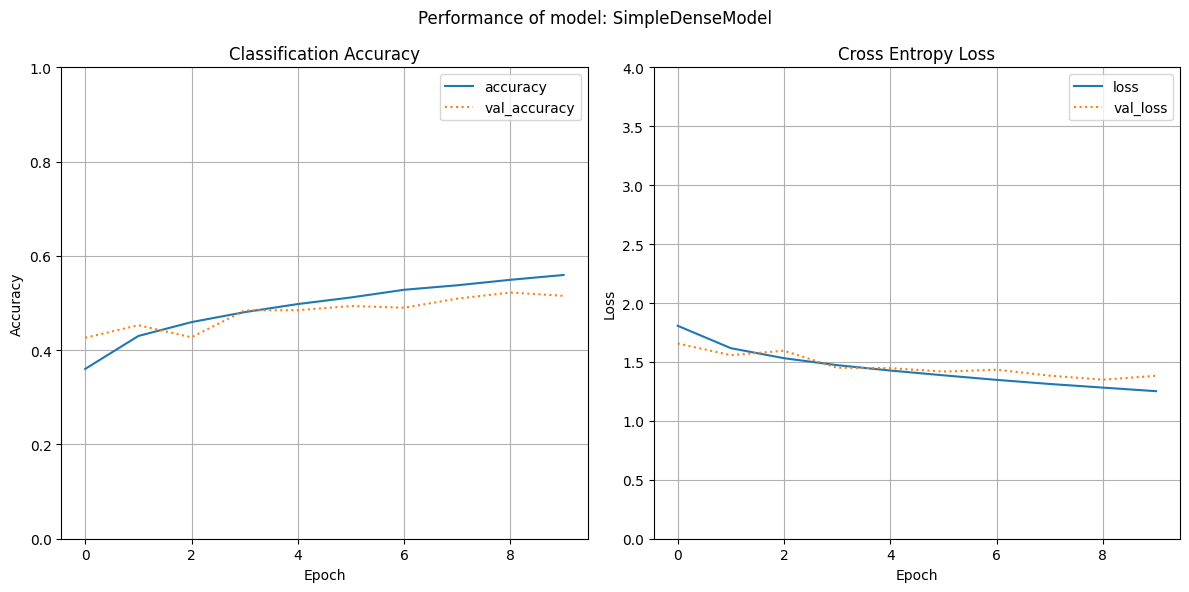

In [34]:
# Reshape the data first
x_train = x_train.reshape(-1, 3072)
x_test = x_test.reshape(-1, 3072)
input_shape = x_train.shape[1:]
# Create the model
model_name = 'SimpleDenseModel'
model = models.Sequential(name=model_name)

# The first fully connected layer
model.add(layers.Dense(3072, activation='relu', input_shape=input_shape, name='3072neurons')) # The first fully connected layer with 3072 perceptrons

# The hidden layer with 256 neurons
model.add(layers.Dense(256, activation='relu', name='256neurons')) # Fully connected layer with 256 peerceptrons

# The output layer
model.add(layers.Dense(10, activation='softmax', name='output_10neurons')) # Output layer with 10 perceptrons

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print a summary of the model
model.summary()

# Train the model
history = model.fit(x_train, labels_train, epochs=EPOCHS_LESS, verbose=2,
                    validation_data=(x_test, labels_test))

# Save and show results
saveModel(model_name, model, history) # save model to a folder
plotModel(model_name, history) # create the plots of performance

Let's evaluate the model.

In [37]:
# m = keras.saving.load_model(prefix+'SimpleDenseModel.keras')
# Reshape the data first
# x_train = x_train.reshape(-1, 3072)
# x_test = x_test.reshape(-1, 3072)
_, acc = model.evaluate(x_test, labels_test)
print(f'Accuracy of {model_name}: %.3f' %(acc*100.0))

313/313 [==============================] - 8s 26ms/step - loss: 1.3825 - accuracy: 0.5153
Accuracy of SimpleDenseModel: 51.530


This model was quite simple, but as we can see, the accuracy we get for the validation set cannot surpass 50%. Let's try a more complex approach, still working with Dense layers. First, let's try with the default batch size of 32

Model: "ThreeLayerDenseModelBatchSize32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 3072neurons (Dense)         (None, 3072)              9440256   
                                                                 
 256neurons (Dense)          (None, 256)               786688    
                                                                 
 64neurons (Dense)           (None, 64)                16448     
                                                                 
 output_10neurons (Dense)    (None, 10)                650       
                                                                 
Total params: 10244042 (39.08 MB)
Trainable params: 10244042 (39.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/25
1563/1563 - 163s - loss: 1.8357 - accuracy: 0.3445 - val_loss: 1.7095 - val_accuracy: 0.3952 - 163s/epoch - 104ms/

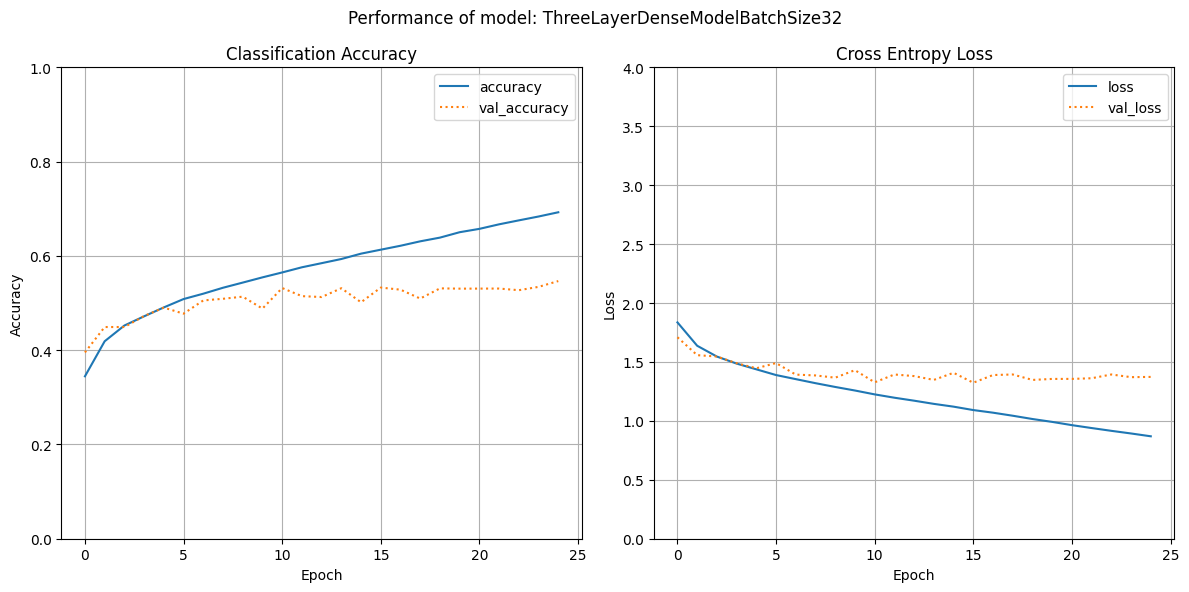

In [10]:
# Data is already in the correct shape

# Create the model
model_name = 'ThreeLayerDenseModelBatchSize32'
model = models.Sequential(name=model_name)

model.add(layers.Dense(3072, activation='relu', input_shape=input_shape, name="3072neurons")) # The first fully connected layer with 3072 perceptrons

model.add(layers.Dense(256, activation='relu', name='256neurons')) # Fully connected layer with 256 peerceptrons

model.add(layers.Dense(64, activation='relu', name='64neurons')) # Fully connected layer with 64 peerceptrons

model.add(layers.Dense(10, activation='softmax', name='output_10neurons')) # Output layer with 10 perceptrons

# Now let's compile the model!
# same as before
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# This time around, let's try with a different batch size
# to see whether we can get different results
history = model.fit(x_train, labels_train, epochs=EPOCHS, verbose=2,
                    validation_data=(x_test, labels_test))
# Save and show results
saveModel(model_name, model, history) # save model to a folder
plotModel(model_name, history) # create the plots of performance

Let's evaluate the model.

In [25]:
_, acc = model.evaluate(x_test, labels_test)
print(f'Accuracy of {model_name}: %.3f' %(acc*100.0))

313/313 [==============================] - 7s 21ms/step - loss: 1.3731 - accuracy: 0.5466
Accuracy of ThreeLayerDenseModelBatchSize32: 54.660


Let's try changing the batch size to 256 and see whether it makes any difference

Model: "ThreeLayerDenseModelBatchSize256"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 3072neurons (Dense)         (None, 3072)              9440256   
                                                                 
 256neurons (Dense)          (None, 256)               786688    
                                                                 
 64neurons (Dense)           (None, 64)                16448     
                                                                 
 output_10neurons (Dense)    (None, 10)                650       
                                                                 
Total params: 10244042 (39.08 MB)
Trainable params: 10244042 (39.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/25
196/196 - 57s - loss: 2.0228 - accuracy: 0.2874 - val_loss: 1.8830 - val_accuracy: 0.3311 - 57s/epoch - 289ms/ste

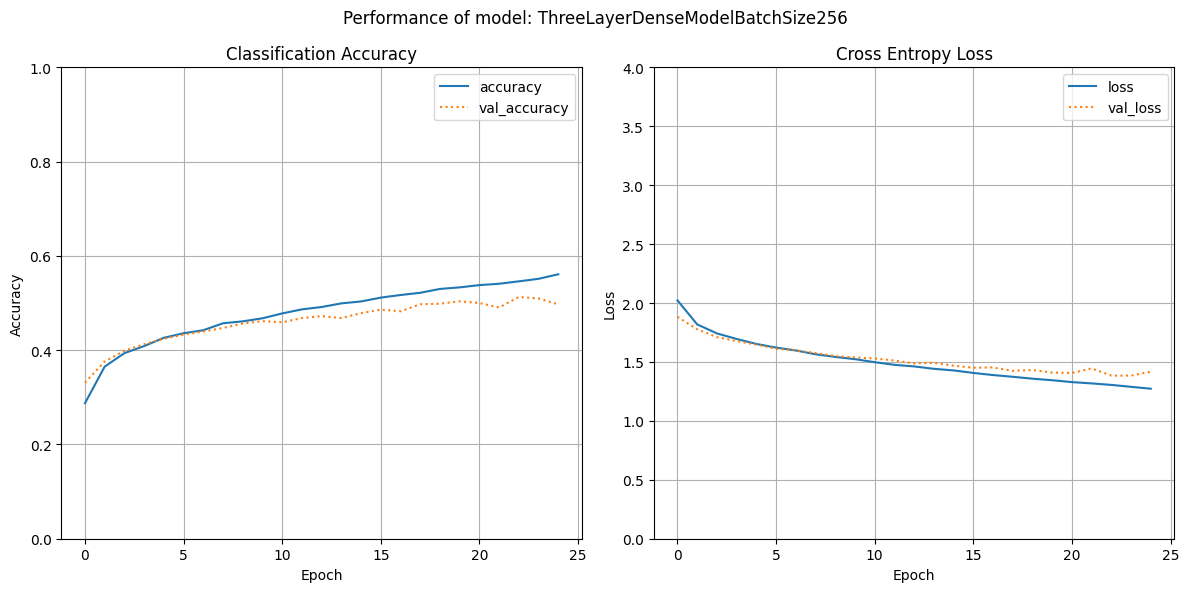

In [11]:
# The model is exactly the same as before, the only change will be in batch size

# Create the model
model_name = 'ThreeLayerDenseModelBatchSize256'
model = models.Sequential(name=model_name)

model.add(layers.Dense(3072, activation='relu', input_shape=input_shape, name="3072neurons")) # The first fully connected layer with 3072 perceptrons

model.add(layers.Dense(256, activation='relu', name='256neurons')) # Fully connected layer with 256 peerceptrons

model.add(layers.Dense(64, activation='relu', name='64neurons')) # Fully connected layer with 64 peerceptrons

model.add(layers.Dense(10, activation='softmax', name='output_10neurons')) # Output layer with 10 perceptrons

# Now let's compile the model!
# same as before
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# This time around, let's try with a different batch size
# to see whether we can get different results
history = model.fit(x_train, labels_train, epochs=EPOCHS,
                    batch_size=256, verbose=2,
                    validation_data=(x_test, labels_test))
# Save and show results
saveModel(model_name, model, history) # save model to a folder
plotModel(model_name, history) # create the plots of performance

Let's evaluate

In [26]:
_, acc = model.evaluate(x_test, labels_test)
print(f'Accuracy of {model_name}: %.3f' %(acc*100.0))

313/313 [==============================] - 8s 26ms/step - loss: 1.4170 - accuracy: 0.4972
Accuracy of ThreeLayerDenseModelBatchSize256: 49.720


It is obvious by now that we cannot get any accuracy over 60% for the validation data. Also, we can see the begginings of how the model starts to overfit the data, both in the accuracy and the loss graph. This model is not efficient at all.

Let's try a different approach, utilizing the power of Convolutional Neural Networks


---

# Convolutional Neural Networks
Our approach so far hasn't been effective. Let's see if we can get a better performing model.

In [8]:
# First and foremost, reshape the data to its original shape
x_train = x_train.reshape(50000, 32, 32, 3)
x_test = x_test.reshape(10000, 32, 32, 3)
input_shape = x_train.shape[1:]

Model: "ConvolutionalThreeLayerNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 3x3__32_filters (Conv2D)    (None, 30, 30, 32)        896       
                                                                 
 2x2 (MaxPooling2D)          (None, 15, 15, 32)        0         
                                                                 
 3x3__32_filters__2 (Conv2D  (None, 13, 13, 32)        9248      
 )                                                               
                                                                 
 2x2__2 (MaxPooling2D)       (None, 6, 6, 32)          0         
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
                                                                 
 512neurons (Dense)          (None, 512)               590336    
                                         

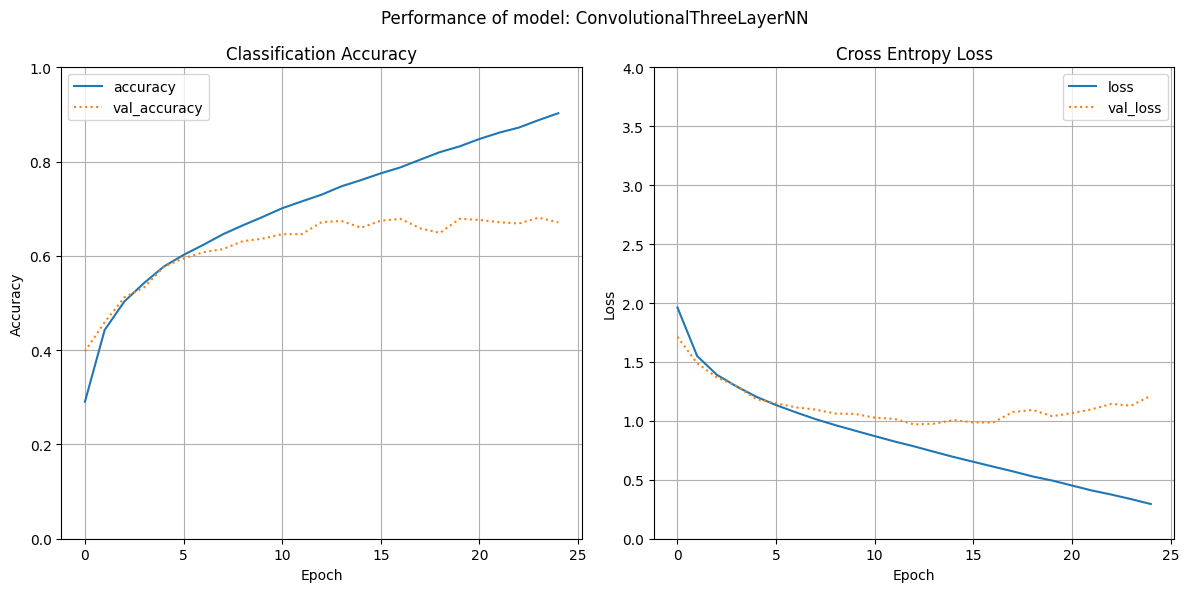

In [14]:
# Create the architecture for the convolutional NN
# Useful info found here
# https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
model_name = 'ConvolutionalThreeLayerNN'

model = models.Sequential(name=model_name)

# Add the convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=input_shape, name='3x3__32_filters'))
model.add(layers.MaxPooling2D((2, 2), name='2x2'))

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        name='3x3__32_filters__2'))
model.add(layers.MaxPooling2D((2, 2), name='2x2__2'))

model.add(layers.Flatten()) # Flatten out the filters

model.add(layers.Dense(512, activation='relu', name='512neurons'))

# no dropout layers as of yet
# output
model.add(layers.Dense(10, activation='softmax', name='10neurons'))

# Print the model summary!
model.summary()

# compile the model
model.compile(optimizer = SGD(learning_rate=0.001, momentum=0.9),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

history = model.fit(x_train, labels_train, epochs=EPOCHS, verbose=2,
                    validation_data=(x_test, labels_test))
# Save and show results
saveModel(model_name, model, history) # save model to a folder
plotModel(model_name, history) # create the plots of performance

Let's evaluate the convolutional model.

In [28]:
_, acc = model.evaluate(x_test, labels_test)
print(f'Accuracy of {model_name}: %.3f' %(acc*100.0))

313/313 [==============================] - 5s 15ms/step - loss: 1.2125 - accuracy: 0.6711
Accuracy of ConvolutionalThreeLayerNN: 67.110


We almost hit 91% in accuracy for the test, but for the validation data we only hit 67%! Also, the loss is 0.29, however for the validation loss it's 1.21. Massive overfitting.

The question is, can this be improved?

---

Let's create a more complex convolutional NN, by adding two more convolutional layers. Later on we will be utilizing a different mixture of dropout percentages in between our layers, in order to reduce overfitting and finalize our model.

Model: "ConvolutionalFiveLayerNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 3x3__32_filters (Conv2D)    (None, 30, 30, 32)        896       
                                                                 
 3x3__32_filters__2 (Conv2D  (None, 28, 28, 32)        9248      
 )                                                               
                                                                 
 2x2 (MaxPooling2D)          (None, 14, 14, 32)        0         
                                                                 
 3x3__32_filters__3 (Conv2D  (None, 12, 12, 32)        9248      
 )                                                               
                                                                 
 3x3__32_filters__4 (Conv2D  (None, 10, 10, 32)        9248      
 )                                                               
                                          

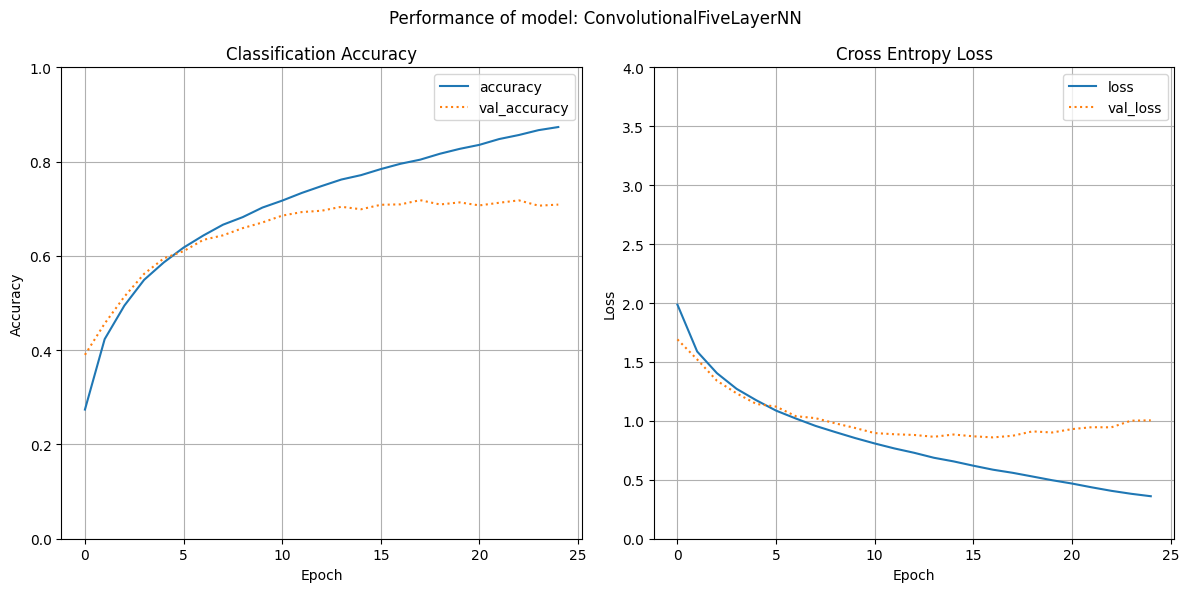

In [15]:
# Create the architecture for this complex model
model_name='ConvolutionalFiveLayerNN'
model = models.Sequential(name=model_name)

model.add(layers.Conv2D(32, (3,3), activation='relu',
                        input_shape=input_shape, name='3x3__32_filters'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', name='3x3__32_filters__2'))
model.add(layers.MaxPooling2D((2, 2), name='2x2'))

# Copy of the above layer
model.add(layers.Conv2D(32, (3,3), activation='relu',
                        input_shape=input_shape, name='3x3__32_filters__3'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', name='3x3__32_filters__4'))
model.add(layers.MaxPooling2D((2, 2), name='2x2__2'))

# Now add a dense layer
model.add(layers.Flatten()) # but first, flatten!

# Let's try something easier on the system with less neurons
model.add(layers.Dense(256, activation='relu', name='256neurons'))

# output
model.add(layers.Dense(10, activation='softmax', name='10neurons'))

# Print model summary
model.summary()

# compile the model
model.compile(optimizer = SGD(learning_rate=0.001, momentum=0.9),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

history = model.fit(x_train, labels_train, epochs=EPOCHS, verbose=2,
                    validation_data=(x_test, labels_test))
# Save and show results
saveModel(model_name, model, history) # save model to a folder
plotModel(model_name, history) # create the plots of performance

Let's evaluate the five layer convolutional model.

In [31]:
_, acc = model.evaluate(x_test, labels_test)
print(f'Accuracy of {model_name}: %.3f' %(acc*100.0))

313/313 [==============================] - 9s 24ms/step - loss: 1.0047 - accuracy: 0.7088
Accuracy of ConvolutionalFiveLayerNN: 70.880


Pretty good. Now, let's finalize our model and see if we can improve it by regularizing using dropout layers.
# Improved CNN model
This following model is an improvement of the previous model. By adding dropout layers, we aim to eliminate the overfitting.

Model: "ConvolutionalFiveLayerDropoutNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 3x3__32_filters (Conv2D)    (None, 30, 30, 32)        896       
                                                                 
 3x3__32_filters__2 (Conv2D  (None, 28, 28, 32)        9248      
 )                                                               
                                                                 
 2x2 (MaxPooling2D)          (None, 14, 14, 32)        0         
                                                                 
 0.25 (Dropout)              (None, 14, 14, 32)        0         
                                                                 
 3x3__32_filters__3 (Conv2D  (None, 12, 12, 32)        9248      
 )                                                               
                                                                 
 3x3__32_filters__4 (Conv2D  (None,

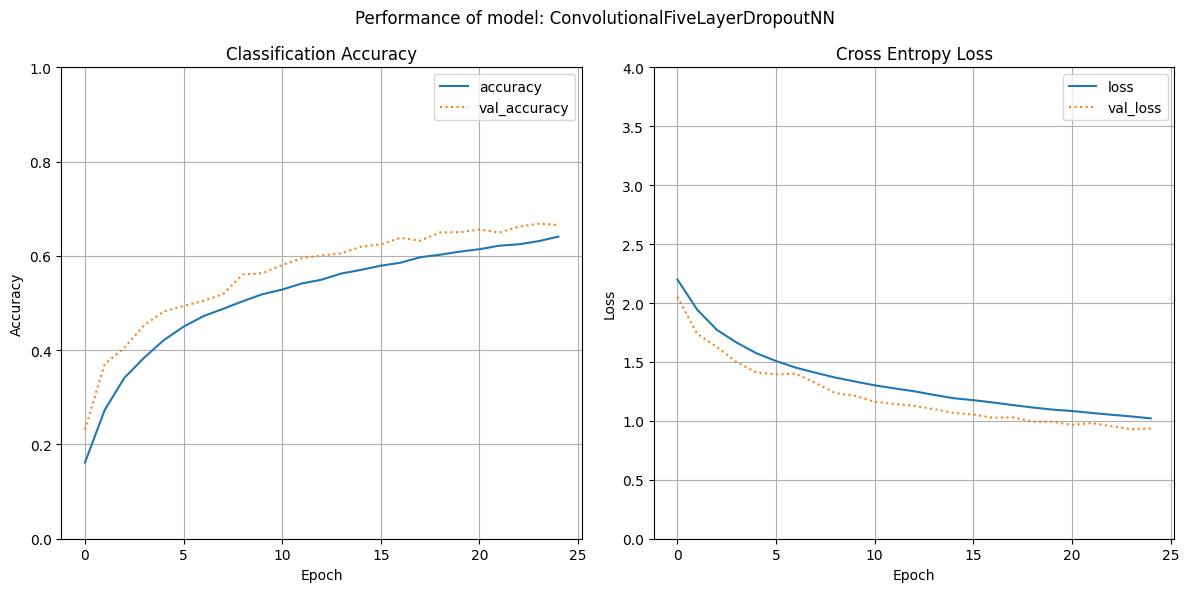

In [32]:
# Create the model's architecture
model_name='ConvolutionalFiveLayerDropoutNN'
model = models.Sequential(name=model_name)

# Convolutional layers
model.add(layers.Conv2D(32, (3,3), activation='relu',
                        input_shape=input_shape, name='3x3__32_filters'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', name='3x3__32_filters__2'))
model.add(layers.MaxPooling2D((2, 2), name='2x2'))
model.add(layers.Dropout(0.25, name='0.25')) # The dropout layer!

# Copy of the above layer
model.add(layers.Conv2D(32, (3,3), activation='relu',
                        input_shape=input_shape, name='3x3__32_filters__3'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', name='3x3__32_filters__4'))
model.add(layers.MaxPooling2D((2, 2), name='2x2__2'))
model.add(layers.Dropout(0.25, name='0.25__2')) # The dropout layer!


# Now add a dense layer
model.add(layers.Flatten()) # but first, flatten!

# Let's use only 128 neurons
model.add(layers.Dense(128, activation='relu', name='128neurons'))
model.add(layers.Dropout(0.5, name='0.50')) # This is quite deep in the NN
# hence a large number (0.5) might be preferable indeed
# output
model.add(layers.Dense(10, activation='softmax', name='10neurons'))

# Print model summary
model.summary()

# compile the model
model.compile(optimizer = SGD(learning_rate=0.001, momentum=0.9),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

history = model.fit(x_train, labels_train, epochs=EPOCHS, verbose=2,
                    validation_data=(x_test, labels_test))
# Save and show results
saveModel(model_name, model, history) # save model to a folder
plotModel(model_name, history) # create the plots of performance

Let's evaluate the improved convolutional model.

In [33]:
_, acc = model.evaluate(x_test, labels_test)
print(f'Accuracy of {model_name}: %.3f' %(acc*100.0))

313/313 [==============================] - 6s 18ms/step - loss: 0.9345 - accuracy: 0.6654
Accuracy of ConvolutionalFiveLayerDropoutNN: 66.540


Excellent. The overfitting is virtually **gone**. Now, how can we be sure this is not some random performance we got (either good or bad) based on the initializations of the weights, and it's actually a well-performing model?

# Final model

To prove it **is** an efficient model, we can train it 5 times using different **kernel initializations** based on a specific seed along with different **batch sizes**, and get the **average** of the accuracies we hit.

But this time round, let's create a really powerful neural network, by increasing the filters in the hidden layers, and also increasing the number of neurons in the dense layer

In [36]:
def make_and_train_model(model_name, seed):
  # Create the model's architecture
  model = models.Sequential(name=model_name)

  # Define a kernel initializer
  kernel_initializer = HeUniform(seed=seed)

  # Convolutional layers
  model.add(layers.Conv2D(32, (3,3), activation='relu',
                          input_shape=input_shape, name='3x3__32_filters',
                          kernel_initializer=kernel_initializer))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', name='3x3__32_filters__2',
                          kernel_initializer=kernel_initializer))
  model.add(layers.MaxPooling2D((2, 2), name='2x2'))
  model.add(layers.Dropout(0.25, name='0.25')) # The dropout layer!

  # Copy of the above layer
  model.add(layers.Conv2D(64, (3,3), activation='relu',
                          input_shape=input_shape, name='3x3__64_filters__3',
                          kernel_initializer=kernel_initializer))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', name='3x3__64_filters__4',
                          kernel_initializer=kernel_initializer))
  model.add(layers.MaxPooling2D((2, 2), name='2x2__2'))
  model.add(layers.Dropout(0.3, name='0.30')) # The dropout layer!


  # Now add a dense layer
  model.add(layers.Flatten()) # but first, flatten!

  # Let's use 256 neurons
  model.add(layers.Dense(256, activation='relu', name='256neurons',
  kernel_initializer=kernel_initializer))
  model.add(layers.Dropout(0.5, name='0.50')) # This is quite deep in the NN
  # hence a large number (0.5) might be preferable indeed

  # output
  model.add(layers.Dense(10, activation='softmax', name='10neurons'))

  # Print model summary
  model.summary()

  # compile the model
  model.compile(optimizer = SGD(learning_rate=0.001, momentum=0.9),
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

  # To speed things up a little, let's alter the batch size
  batch_size = 128
  history = model.fit(x_train, labels_train, epochs=EPOCHS_MID, verbose=2,
                      batch_size=batch_size,
                      validation_data=(x_test, labels_test))
  return (model, history)

	i: 0 at 26/11/2023 14:53:43
Model: "FinalCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 3x3__32_filters (Conv2D)    (None, 30, 30, 32)        896       
                                                                 
 3x3__32_filters__2 (Conv2D  (None, 28, 28, 32)        9248      
 )                                                               
                                                                 
 2x2 (MaxPooling2D)          (None, 14, 14, 32)        0         
                                                                 
 0.25 (Dropout)              (None, 14, 14, 32)        0         
                                                                 
 3x3__64_filters__3 (Conv2D  (None, 12, 12, 64)        18496     
 )                                                               
                                                                 
 3x3__64_filters__4 (Conv2D  

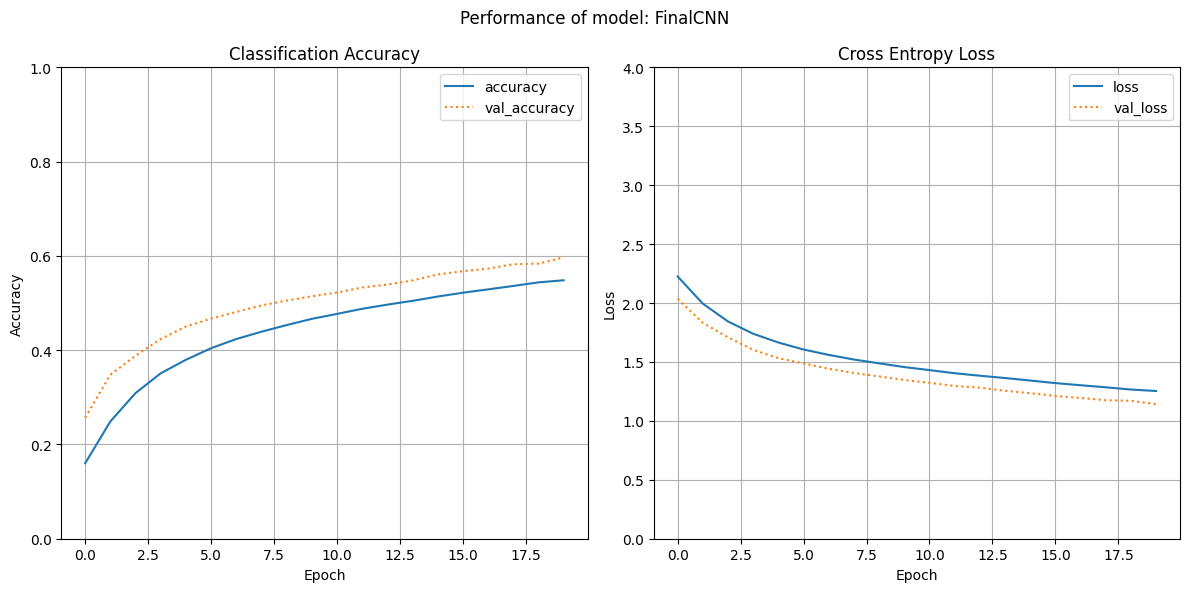

In [37]:
# due to the lack of computational power, we will only iterate 5 times
ITERATIONS = 5

accuracy = np.zeros(EPOCHS_MID)
val_accuracy = np.zeros(EPOCHS_MID)
loss = np.zeros(EPOCHS_MID)
val_loss = np.zeros(EPOCHS_MID)
model_list = []
ACCU = 0
model_name='FinalCNN'

# hist = make_and_train_model(model_name, SEED)

for i in range(ITERATIONS):
  now = datetime.now()
  dt_str = now.strftime("%d/%m/%Y %H:%M:%S")
  print('\ti:', i, 'at', dt_str)
  (model, hist) = make_and_train_model(model_name, SEED)
  model_list.append(model)
  # saveModel(model_name+'_'+str(i), model, history)
  saveModel(f'{model_name}_{i}', model, hist)

  # evaluate model
  _, accu = model.evaluate(x_test, labels_test)
  ACCU += accu

  # get data
  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  l = hist.history['loss']
  val_l = hist.history['val_loss']

  # convert to numpy arrays
  acc = np.asarray(acc)
  val_acc = np.asarray(val_acc)
  l = np.asarray(l)
  val_l = np.asarray(val_l)

  # add to previous data
  accuracy = np.add(accuracy, acc)
  val_accuracy = np.add(val_accuracy, val_acc)
  loss = np.add(loss, l)
  val_loss = np.add(val_loss, val_l)

# get mean values
accuracy = accuracy/ITERATIONS
val_accuracy = val_accuracy/ITERATIONS
loss = loss/ITERATIONS
val_loss = val_loss/ITERATIONS
_plotModel(model_name, accuracy.tolist(), val_accuracy.tolist(), loss.tolist(), val_loss.tolist())

# evaluation of all models
ACCU /= ITERATIONS
print(f'Accuracy of {model_name}: %.3f' %(ACCU*100.0)) # This is the mean accuracy

In [26]:
# Predict labels for test data
predictions = model.predict(x_test) # get the last model, either way they're all about the same
predicted_labels = np.argmax(predictions, axis=1) # Get the predictions for each example

true_labels = y_test.reshape(-1) # reshape the data to match predicted_labels shape


In [21]:
label_names = {0:'airplane',
               1:'automobile',
               2:'bird',
               3:'cat',
               4:'deer',
               5:'dog',
               6:'frog',
               7:'horse',
               8:'ship',
               9:'truck'}

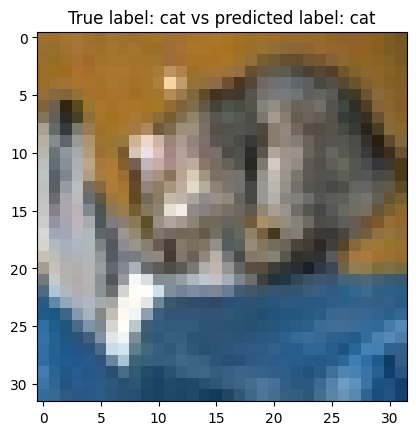

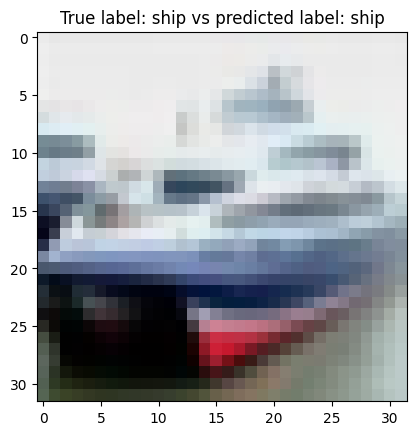

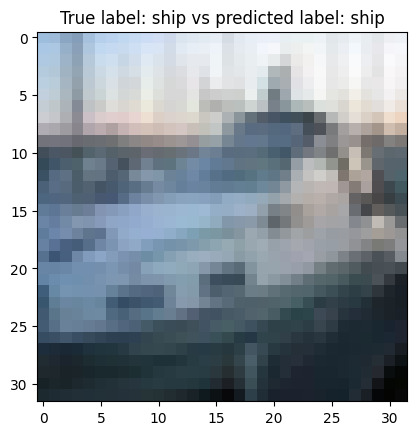

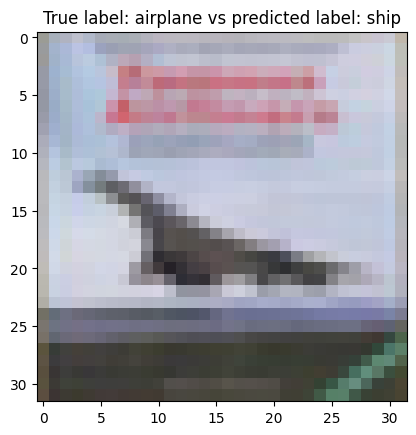

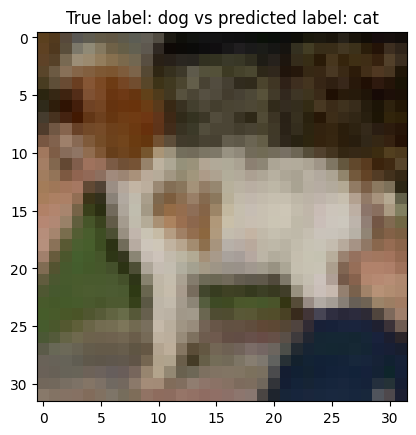

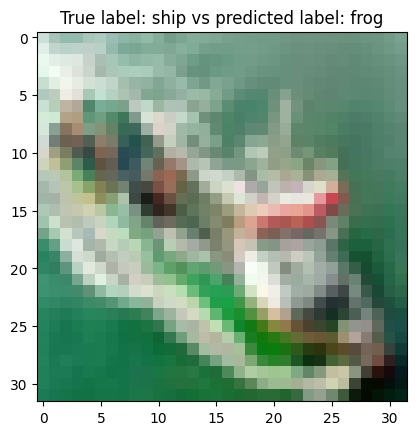

In [32]:
# Showcase three correctly predicted examples
# As well as three incorrectly predicted examples
counter_accurate = 0
counter_inaccurate = 0
def showImage(image, true_label, predicted_label, label_names):
  true_label_name = label_names[true_label]
  predicted_label_name = label_names[predicted_label]
  plt.imshow(image)
  plt.title(f'True label: {true_label_name} vs predicted label: {predicted_label_name}')
  plt.show()

for i, pred in enumerate(predicted_labels):
  if pred == true_labels[i] and counter_accurate < 3:
    showImage(x_test[i], true_labels[i], pred, label_names)
    counter_accurate += 1
  if pred != true_labels[i] and counter_inaccurate < 3:
    showImage(x_test[i], true_labels[i], pred, label_names)
    counter_inaccurate += 1